# Fetching crypto and tweets data.

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from crypto_api import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)

# Analysis of tweets

In [5]:
'''
TODO: GENERAL DATA TASKS:
0) find a way to deal with multiple tweets for a day
1) merge 2 datasets into 
2) imput missing data, maybe try interpolation or expectation maximization
    2.1) compare with mean, median imput methods
3) ivestigate relationship within data, maybe correlation matrix etc
'''

tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
# tweets_df['date'] = pd.to_datetime(tweets_df['date'])

# btc_df = pd.read_csv('Data/btc_data.csv')
# btc_df['time'] = pd.to_datetime(btc_df['time'])

# tweets_df = tweets_df[tweets_df['date'].dt.date.isin(btc_df['time'].dt.date)]
                                               
# tweets_df = (tweets_df
#              .dropna(axis=1, how='all')
#              .drop(['vibe','cashtags'], axis=1)) # 1 and 18 notna values respectively  

## Dealing with sparse columns

In [6]:
sparse_cols = tweets_df.columns[tweets_df.notnull().mean() < 1.0].values.copy()

mod_tweets_df = tweets_df.copy()
mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)                 
                 .reset_index(drop=True)
                 .copy())

mod_tweets_df = mod_tweets_df.drop(['lang'], axis=1)

## Data cleaning and preprocessing

In [7]:
encoder = OrdinalEncoder()
mod_tweets_df['sourceLabel_encoded'] = encoder.fit_transform(mod_tweets_df['sourceLabel'].values.reshape(-1, 1))
mod_tweets_df['isReplied']   = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['inReplyToUser']]
mod_tweets_df['isMentioned'] = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['mentionedUsers']]

#mod_tweets_df = mod_tweets_df.drop(['sourceLabel','inReplyToUser','mentionedUsers'], axis=1)


def extract_dict(line: str, prepare_to_df: False):
    """Extracts data from a dict represented as string and makes it a dict.

    ## Parameters:
        line (str): row of a Series/DataFrame to be preprocessed.
        prepare_to_df (bool): prepares extracted dict to be wrapped into DataFrame.

    ## Returns:
        dict: extracted dict from string.
    """    

    extracted_content = dict(re.findall(r"'(\w+)': '?({.*}|datetime.datetime\(.*\)|[\w\d/:\. ]*)'?", line))
    
    # Wraps dict values into lists to be easily represented as a DataFrame row.
    if prepare_to_df:
        for key,value in extracted_content.items():
            if value == '':
                extracted_content[key] = [None]
            else:
                extracted_content[key] = value
        
    return extracted_content


extracted_df = (pd.DataFrame([*mod_tweets_df['user']
                              .apply(lambda x: extract_dict(x, True))])
                )

mod_tweets_df = (pd.concat([mod_tweets_df, extracted_df], axis=1)
            .drop(['user','username','id','displayname','verified','created',
                    'location','protected','profileImageUrl','profileBannerUrl',
                    'rawDescription','renderedDescription','favouritesCount',
                    'friendsCount','mediaCount','statusesCount'], axis=1))

In [8]:
# Converting columns containing numbers to int after extraction.
for column in mod_tweets_df:
    if 'Count' in column:
        mod_tweets_df[column] = mod_tweets_df[column].astype('Int64').copy()

In [9]:
mod_tweets_df[['rawContent','isReplied','isMentioned']].query("rawContent.str.contains('@')")

mod_tweets_df['mentionsCount'] = mod_tweets_df['rawContent'].str.count(r'@[\w\d]+')
mod_tweets_df['mentions'] = mod_tweets_df['rawContent'].apply(lambda x : re.findall(r'(@[^\s]+)', x))

count = 0
for a,b in mod_tweets_df[['mentionsCount','mentions']].values:
    if a==len(b):
        count +=1 
print(count==len(mod_tweets_df))

mod_tweets_df['charCount'] = mod_tweets_df['rawContent'].apply(lambda x: len(x))
mod_tweets_df = mod_tweets_df.drop('descriptionLinks', axis=1)

True


In [10]:
#links = tweets_df[tweets_df.columns[tweets_df.columns.isin(mod_tweets_df.columns)==False]]['links'].value_counts().copy()

tweets_df[tweets_df['rawContent']=='True']['quotedTweet'].iloc[0]

'{\'url\': \'https://twitter.com/ggreenwald/status/1625871270737809408\', \'date\': datetime.datetime(2023, 2, 15, 14, 54, 52, tzinfo=datetime.timezone.utc), \'rawContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'renderedContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'id\': 1625871270737809408, \'user\': {\'username\': \'ggreenwald\', \'id\': 16076032, \'displayname\': \'Glenn Greenwald\', \'rawDescription\': \'Journalist; Author; Host, @SystemUpdate_; Columnist, @Folha; Co-Founder: The Intercept, @TheInterceptBr; @abrigo_hope, @FreedomofPress, @ongcriadefavela.

In [11]:
import re
import json
import datetime


def clean_text(raw_text):    
    cleaned_text = re.sub(r' \'?(displayname|renderedDescription)\'?: (.*?)(\'|None),', '', raw_text)
    cleaned_text = (cleaned_text
                    .replace("'",'"')
                    .replace('None','null')
                    .replace('True','true')
                    .replace('False','false'))
    # cleaned_text = re.sub(r'(\w+)"(\w+)', r"\1'\2", cleaned_text)
    
    return cleaned_text


def deserialize(text):    
    deserialized_texts = []
    extract_dicts = re.findall(r'{.*?}',text)
    
    for str_dict in extract_dicts:
        cleaned_text = clean_text(str_dict)

        pattern = r'datetime.datetime\(.*\)'
        cleaned_text = re.sub(f'({pattern})',r'"\1"',cleaned_text)
        
        deserialized_text = json.loads(cleaned_text)
        
        if deserialized_text['created']!=None:
            deserialized_text['created'] = eval(deserialized_text['created'])
        
        deserialized_texts.append(deserialized_text)

    return deserialized_texts
    
    
mod_tweets_df = mod_tweets_df.drop(['links','media','link','inReplyToUser'], axis=1)
mod_tweets_df['mentionedUsers'] = mod_tweets_df['mentionedUsers'].apply(lambda x: deserialize(x) if type(x)==str else None)

In [12]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
mod_tweets_df[encoder.categories_[0]] =  encoder.fit_transform(mod_tweets_df[['sourceLabel']]).toarray()
mod_tweets_df = mod_tweets_df.drop(['renderedContent','conversationId',
                                    'sourceLabel','mentions', 
                                    'cashtags','vibe'], axis=1)

object_features = mod_tweets_df[mod_tweets_df.dtypes[mod_tweets_df.dtypes==object].index].copy()
object_features['mentionsCount'] = object_features['mentionedUsers'].apply(lambda x: len(x) if x!=None else 0)
object_features = object_features.drop(['mentionedUsers','label'], axis=1)

def extract_quoted_tweet(tweet):
    if type(tweet)!=float:
        text = re.findall(r"'rawContent': '?(.*?)'?, 'renderedContent'",tweet)[0]
        name = re.findall(r"'user': {'username': '?(.*?)'?,",tweet)[0]
        result = pd.Series({'quoted_text':text, 'quoted_username':name})
    else:
        result = pd.Series({'quoted_text':None, 'quoted_username':None})
        
    return result


extracted_quoted_tweets = object_features['quotedTweet'].apply(lambda x: extract_quoted_tweet(x))
object_features = pd.concat([object_features, extracted_quoted_tweets], axis=1)

# mergins cleaned object cols
mod_tweets_df[object_features.columns] = object_features.copy()
mod_tweets_df = mod_tweets_df.drop(['mentionedUsers','label','quotedTweet'], axis=1)

In [13]:
mod_tweets_df['rawContent'] = mod_tweets_df['rawContent'].str.replace('@','')

# NLP Model Bulding

## Preprocessing and vectorizing

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, matutils, utils, models
import spacy


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    url_pattern = [{"label": "URL",
                    "pattern": [{"LIKE_URL": True}]}]

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(url_pattern)
    
    texts_out = []
    if type(texts)!=list:
        texts = [texts]
    
    for text in texts:
        # TODO: consider using nlp.pipe which should be faster
        doc = nlp(text)
        cleaned_text = []
        for token in doc:
            if token.ent_type_ != 'URL' and not token.is_stop and token.pos_ in allowed_postags:
                cleaned_text.append(token.lemma_)
        final = ' '.join(cleaned_text)
        texts_out.append(final)

    return texts_out


def create_ngrams(texts):
    data_words = []
    for text in texts:
        new = utils.simple_preprocess(text)
        data_words.append(new)

    bigrams_phrases  = models.Phrases(data_words, min_count=3, threshold=50)
    trigrams_phrases = models.Phrases(bigrams_phrases[data_words], threshold=50)

    bigram  = models.phrases.Phraser(bigrams_phrases)
    trigram = models.phrases.Phraser(trigrams_phrases)

    data_bigrams = [bigram[doc] for doc in data_words]
    data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]
    
    return data_bigrams_trigrams


def vectorize_texts(texts_ngrams):
    id2word = corpora.Dictionary(texts_ngrams)
    corpus = [id2word.doc2bow(text) for text in texts_ngrams]
    return id2word, corpus


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def make_custom_pipeline(steps):
    for i, step in enumerate(steps):
        steps.insert(i, (step[0], FunctionTransformer(step[1])))
        steps.remove(step)

    return Pipeline(steps)



steps = [('lemmatization', lemmatization),
         ('trigrams', create_ngrams),
         ('vectorization', vectorize_texts)]

preprocessing_pipeline = make_custom_pipeline(steps)
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())


def prepare_tfidf():
    with open('lemmatized_texts.txt', 'r', encoding="utf-8") as f:
        lemmatized_texts = f.readlines()
    
    lemmatized_texts = [line.replace('\n','') for line in lemmatized_texts]

    lemmatized_texts = lemmatization(mod_tweets_df['rawContent'])

    data_bigrams_trigrams = create_ngrams(lemmatized_texts)
    id2word, corpus = vectorize_texts(data_bigrams_trigrams)

    tfidf = models.TfidfModel(corpus, id2word=id2word)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.6,
                                       min_df=5,
                                       ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_texts)

    id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
    corpus = matutils.Sparse2Corpus(tfidf_matrix.T)

    low_value = 0.03
    words = []
    words_missing_in_tfidf = []

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id,_ in tfidf[bow]]
        bow_idf = [id for id,_ in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        
        for item in drops:
            words.append(id2word[item])
        
        # words with tfidf score of 0 will be missing
        words_missing_in_tfidf = [id for id in bow_idf if id not in tfidf_ids]
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow

In [16]:
from gensim.models import CoherenceModel


def bayesian_tuning(model, params_grid: dict, texts, verbose=False):
    # TODO: implement bayesian tuning
    models_scores = {}
    for i in range(95,170,5):
        lda_model = model(corpus=params_grid['corpus'],
                          num_topics=i,
                          id2word=params_grid['id2word'],
                          random_state=1,
                          passes=10,
                          per_word_topics=True)
        
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=texts, 
                                             corpus=params_grid['corpus'], 
                                             dictionary=params_grid['id2word']
                                             )
        coherence_score = coherence_model_lda.get_coherence()
        
        models_scores.update({lda_model: coherence_score})
        
        if verbose:
            print(f'Topics {i:<3}: {coherence_score}')
    
    return models_scores


params_grid = {'corpus':corpus,  
               'num_topics':10, 
               'id2word':id2word, 
               'random_state':1, 
               'update_every':1, 
               'chunksize':3000, 
               'passes':2}

# lda_models_scores = bayesian_tuning(LdaMulticore, params_grid, texts, verbose=True)

In [17]:
import pyLDAvis.gensim_models as gensimvis
from gensim.models import LdaMulticore
import pyLDAvis


pyLDAvis.enable_notebook()

lda_model = LdaMulticore(corpus=corpus,
                         num_topics=25,
                         id2word=id2word,
                         random_state=1,
                         passes=10,
                         per_word_topics=True)

vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.105182  0.083713       1        1  5.650125
13     0.015393  0.053214       2        1  5.081732
11     0.159003  0.092975       3        1  4.742547
6      0.080403 -0.025796       4        1  4.449659
5     -0.092141 -0.067345       5        1  4.429829
20     0.015359 -0.021391       6        1  4.428024
21     0.108642 -0.007923       7        1  4.426282
24    -0.077500 -0.031594       8        1  4.294337
8      0.065904 -0.088757       9        1  4.279917
15    -0.002152 -0.035643      10        1  4.154369
9      0.068946  0.068873      11        1  4.111028
22    -0.039228  0.111827      12        1  4.018633
23    -0.046442 -0.050620      13        1  3.893653
1     -0.037796 -0.015176      14        1  3.855592
18    -0.025114  0.057555      15        1  3.715205
10    -0.004732 -0.043737      16        1  3.654869
7      0.017666 -0.055782      17        1  3.629880
2      0.027550 -0.023876      18        1  3.621568
3      0.013691  0.064803      19        1  3.617594
0     -0.087942  0.112126      20        1  3.507700
16     0.010173 -0.128275      21        1  3.503860
12    -0.034567 -0.133830      22        1  3.463494
17    -0.054699 -0.008759      23        1  3.414686
19     0.010034 -0.004770      24        1  3.123941
14    -0.195632  0.098188      25        1  2.931479, topic_info=          Term        Freq       Total Category  logprob  loglift
1001   exactly  355.000000  355.000000  Default  30.0000  30.0000
29        true  375.000000  375.000000  Default  29.0000  29.0000
71        good  775.000000  775.000000  Default  28.0000  28.0000
8         work  602.000000  602.000000  Default  27.0000  27.0000
399     launch  264.000000  264.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
295      major   12.157652  151.293843  Topic25  -5.5109   1.0084
215   probably   11.472213  252.488225  Topic25  -5.5689   0.4382
32       great   12.384255  545.845850  Topic25  -5.4924  -0.2562
1249     money   10.585674  120.819300  Topic25  -5.6493   1.0949
160       cool   10.350379   96.726623  Topic25  -5.6718   1.2948

[1820 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
185       9  0.898969  absolutely
185      15  0.006115  absolutely
185      16  0.079501  absolutely
4181      1  0.717137   absurdity
3546      2  0.099214    absurdly
...     ...       ...         ...
638      12  0.073618   yesterday
638      17  0.515325   yesterday
5278     16  0.837772       yield
9611     17  0.923143        yike
7148     19  0.859400   yukaichou

[6688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 14, 12, 7, 6, 21, 22, 25, 9, 16, 10, 23, 24, 2, 19, 11, 8, 3, 4, 1, 17, 13, 18, 20, 15])

In [18]:
# for prediction
def prepare_new_texts(texts: list[str]):
    steps = [('lemmatization', lemmatization),
            ('trigrams', create_ngrams)]

    corpus_pipeline = make_custom_pipeline(steps)
    texts_ngrams = corpus_pipeline.transform(texts)
    corpus = [id2word.doc2bow(text) for text in texts_ngrams]
    
    return corpus

In [19]:
mod_tweets_df['vectorized']  = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())[1]
mod_tweets_df['TopicsProbs'] = mod_tweets_df['vectorized'].apply(lambda x: dict(lda_model.get_document_topics(x, minimum_probability=0)))

## Merging NLP results into crypto data.

In [20]:
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
btc_df = btc_df.rename(columns={'time':'date'})
btc_df['date'] = pd.to_datetime(btc_df['date']).dt.date

topics_tweets_df = pd.concat([mod_tweets_df, pd.DataFrame(mod_tweets_df['TopicsProbs'].tolist())], axis=1).copy()

topics_tweets_df['date'] = pd.to_datetime(topics_tweets_df['date']).dt.date
#btc_df['date'] = pd.to_datetime(btc_df['date'])

In [21]:
merged_pieces = pd.merge(btc_df, topics_tweets_df, on='date', how='inner')
numeric_cols_names = merged_pieces.columns[merged_pieces.dtypes!=object][1:]
merged_pieces = merged_pieces[numeric_cols_names].dropna(axis=1)

In [26]:
topics_tweets_df

,date,rawContent,replyCount,retweetCount,likeCount,quoteCount,retweetedTweet,inReplyToTweetId,coordinates,place,...,15,16,17,18,19,20,21,22,23,24
0,2010-06-04,"Please ignore prior tweets, as that was someon...",1198,658,6359,326,NaN,NaN,NaN,NaN,...,0.006669,0.006669,0.006669,0.006669,0.006669,0.006669,0.006669,0.006669,0.006669,0.006669
1,2011-12-01,I made the volume on the Model S http://t.co/w...,28,12,80,8,NaN,NaN,NaN,NaN,...,0.008005,0.288959,0.008005,0.008005,0.008005,0.008005,0.008005,0.008005,0.008005,0.008005
2,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,42,27,198,7,NaN,NaN,NaN,NaN,...,0.003642,0.003642,0.003642,0.003642,0.003642,0.003642,0.003642,0.003642,0.478322,0.003642
3,2011-12-03,That was a total non sequitur btw,42,17,144,8,NaN,NaN,NaN,NaN,...,0.010014,0.010014,0.010014,0.010014,0.010014,0.010014,0.010014,0.010014,0.010014,0.010014
4,2011-12-03,"Great Voltaire quote, arguably better than Twa...",35,34,86,5,NaN,NaN,NaN,NaN,...,0.004004,0.004004,0.004004,0.296092,0.004004,0.004004,0.004004,0.004004,0.339342,0.004004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,2023-04-09,DimaZeniuk SpaceX SirineAti captainarve andst7...,202,249,3511,30,NaN,1.644868e+18,NaN,NaN,...,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445
18312,2023-04-09,DimaZeniuk SpaceX SirineAti captainarve andst7...,1299,1216,20873,147,NaN,1.644756e+18,NaN,NaN,...,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445,0.004445
18313,2023-04-09,teslaownersSV Got to break a few eggs to make ...,4826,4900,113346,391,NaN,1.644817e+18,NaN,NaN,...,0.807966,0.008001,0.008001,0.008001,0.008001,0.008001,0.008001,0.008001,0.008001,0.008001
18314,2023-04-09,Jason DeanPreston GrowSF Good question,166,179,2663,14,NaN,1.644820e+18,NaN,NaN,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333


In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = merged_pieces.drop('close', axis=1)
y = merged_pieces['close']

train, test, labels_train,labels_test = train_test_split(X, y, train_size=0.8)
# labels_train = train['close'].values
# labels_test  = test['close'].values

dtrain = xgb.DMatrix(train, label=labels_train)
dtest  = xgb.DMatrix(test, label=labels_test)

param = {'max_depth': 10, 'objective': 'reg:squarederror'}
param['nthread'] = 8
param['eval_metric'] = 'mape'
#param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train'), (dtest, 'test')]

num_round = 30
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mape:0.70005	test-mape:0.70010
[1]	train-mape:0.49008	test-mape:0.49031
[2]	train-mape:0.34307	test-mape:0.34341
[3]	train-mape:0.24024	test-mape:0.24069
[4]	train-mape:0.16827	test-mape:0.16876
[5]	train-mape:0.11788	test-mape:0.11833
[6]	train-mape:0.08269	test-mape:0.08299
[7]	train-mape:0.05811	test-mape:0.05836
[8]	train-mape:0.04089	test-mape:0.04114
[9]	train-mape:0.02884	test-mape:0.02916
[10]	train-mape:0.02039	test-mape:0.02081
[11]	train-mape:0.01448	test-mape:0.01499
[12]	train-mape:0.01039	test-mape:0.01097
[13]	train-mape:0.00756	test-mape:0.00823
[14]	train-mape:0.00571	test-mape:0.00644
[15]	train-mape:0.00449	test-mape:0.00526
[16]	train-mape:0.00369	test-mape:0.00452
[17]	train-mape:0.00316	test-mape:0.00400
[18]	train-mape:0.00283	test-mape:0.00367
[19]	train-mape:0.00264	test-mape:0.00351
[20]	train-mape:0.00249	test-mape:0.00335
[21]	train-mape:0.00242	test-mape:0.00330
[22]	train-mape:0.00233	test-mape:0.00321
[23]	train-mape:0.00224	test-mape:0.00313
[2

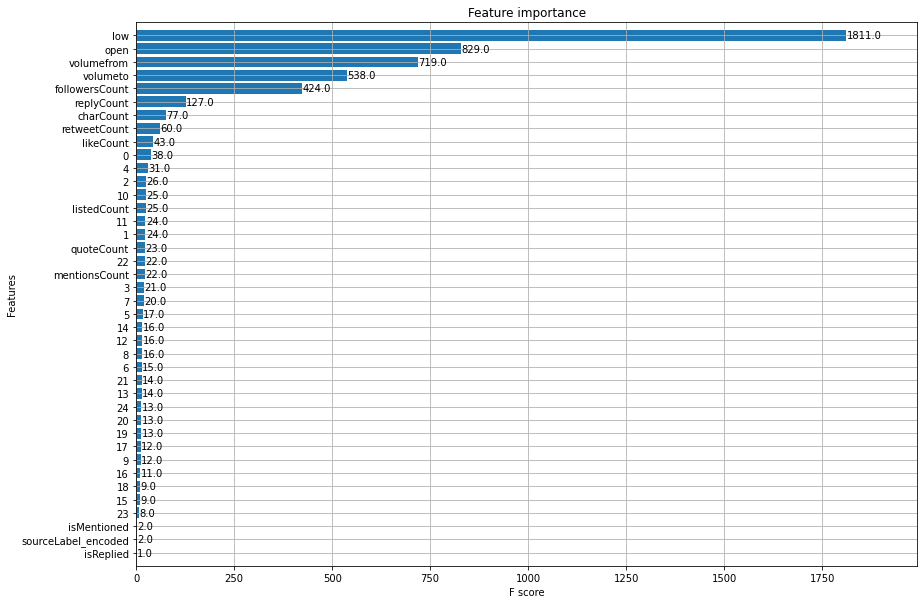

In [24]:
ax = xgb.plot_importance(bst, height=0.8)
fig = ax.figure
fig.set_size_inches(14, 10)

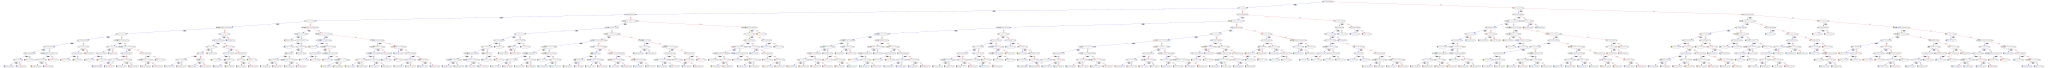

In [25]:
xgb.to_graphviz(bst, num_trees=15)